### In this series of notes, we focus on the Dynamic Time Warping algorithm and discuss its potential application in algorithmic trading. If you have any comments, please let us know.




## In this first article, we introduce the basic idea of Dynamic Time Warping (DTW) briefly and its python implementation. 

#### DTW is a way to measure the distance between two sequences, which is distinguished from our usual (sum of) Euclidean distances due to its robustness to "warping". 

#####  Recall that the Euclidean distance between two vector, say, $x$ and $y$ are:
$$ D(x, y) = \sqrt{ (x_1 - y_1)^2 + (x_2 - y_1)^2 } $$.

##### Then a straight forward way to compute the distance between two sequences is sum of the Euclidean distances between every single points and its counterpart:
$$ Distance(A,B) = D(A_0, B_0) + D(A_1, B_1) + ....D(A_n, B_n) $$ 
##### where $A = A_0, A_1,....A_n$ and $B = B_0, B_1...B_n$ are two sequences. 

##### Everything looks good, right? Not really. In reality, the sequencess we got are not ideal at all. Most of time they are noisy or missing some part of it. So we need to know how to deal with those "twisted" sequences. 

##### Due to its ability to deal with those warping complexity, it has been widly used in the field of speech recognition. A very nice example (in Chinese) is in [1].

##### Note that DTW gives us a "measure" not a "metric" though we mentioned that it is a way to measure the distance between two sequences in the very beginning. The triangle inequality is not guaranteed [2] (it is, however, obeyed for most of time).



In [1]:
import sys
print("system info:\n" + sys.version)

%matplotlib inline

import os

system info:
2.7.12 |Anaconda 2.5.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


In [2]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt

* Distance Matrix

#### Let us first construct the distance matrix. If we have two sequences $(a,b,c)$ and $(A,B,C)$, then the distance matrix is defined as:
$
Distance\_Matrix = 
\begin{pmatrix}
dist(a,A) &  dist(a,B) & dist(a,C) \\
dist(b,A) &  dist(b,B) & dist(b,C) \\
dist(c,A) &  dist(c,B) & dist(c,C)
\end{pmatrix}
$


In [3]:
def distance_matrix(arr1, arr2):
    """
    In this function, we compute the Euclidean distance matrix between two sequences.
    
    We use two for loops to fill distance values into the cells for illustration reason.
    
    For a more compact form, simply use
    distance = [ [ np.sqrt( (arr1[i] - arr2[j])**2 ) for i in np.arange(len(arr1))] for j in np.arange(len(arr2))]
    
    """
    

    # construct an empty array
    distance = np.ndarray(shape = (len(arr1), len(arr2)))
    
    for row in np.arange(len(arr1)):
        for col  in np.arange(len(arr2)):
            distance[row,col] = np.sqrt( (arr1[row] - arr2[col])**2 )
    
    return distance

In [4]:
# randomly generate two sequences
np.random.seed(123)
arr1 = np.random.choice(20, 5)
arr2 = np.random.choice(20, 5)
print "Array 1:", arr1
print "Array 2:", arr2

Array 1: [13  2  2  6 17]
Array 2: [19 10  1  0 17]


In [5]:
a = distance_matrix(arr1, arr2)
pd.DataFrame(a, index = arr1, columns = arr2)

,19,10,1,0,17
13,6.0,3.0,12.0,13.0,4.0
2,17.0,8.0,1.0,2.0,15.0
2,17.0,8.0,1.0,2.0,15.0
6,13.0,4.0,5.0,6.0,11.0
17,2.0,7.0,16.0,17.0,0.0


* Dynamic Time Warping (DTW)

#### Now let us discuss the DTW algorithm with no constraints. If we would like to start the upper left corner of the distnace matrix and walk down to the lower right corner (that is, the fixed endpoints), then DTW is a way to figure out a path with the smallest accumulated distance.

#### The only rule is that you can only move $\downarrow$, $\searrow$ and $\rightarrow$ (monotonically increasing). Figure below shows the DTW path and basic step pattern, which is taken from Ref. [3]

<img src="https://www.dropbox.com/s/lv7o8ogwc1s53tj/image23.png?dl=1", width="512">


#### The solution is described by this recursion relation: $$ \gamma(i,j) = dist(q_i, t_j) + min\{ \gamma(i-1,j), \gamma(i-1,j-1), \gamma(i,j-1)   \},$$ where $\gamma(i,j)$ is the accumulated distance at cell $(i,j)$ and $dis(q_i, t_j)$ is the distance between the $i$th element of query sequence Q and the $j$th element of template sequence T.


In [6]:
def dtw_basic(arr1, arr2, alignment_curve = False, gen_plot = True):
    """
    This function shows a basic DTW calculation with two multi-dimensional arrays.

    Notice that we modified the outputs a litte, it outputs (dtw_distance, dtw_matrix) now.
    """

    # initialize the dtw array
    dtw = np.zeros(shape = (len(arr1), len(arr2)))

    for row in range(dtw.shape[0]):
        for col in range(dtw.shape[1]):
            # calculate distance between arr1[row] and arr2[col]
            # here we use Euclidean distance
            dist = np.sqrt( np.sum( (arr1[row] - arr2[col])**2 ) )

            # the starting point
            if row == 0 and col == 0:
                dtw[row, col] = dist
            # we can only go right along the upmost row
            elif row == 0:
                dtw[row, col] = dist + dtw[row, col - 1]
            # we can only go down along the leftmost column
            elif col == 0:
                dtw[row, col] = dist + dtw[row-1, col]
            # the recursive relation
            else:
                dtw[row, col] = dist + min(dtw[row-1, col], dtw[row-1, col-1], dtw[row, col-1])

    # alignment curve
    if alignment_curve:

        row = 0
        col = 0
        alignment = [ [row, col] ]

        while row != dtw.shape[0] - 1 or col != dtw.shape[1] - 1:
            if row == dtw.shape[0] - 1:
                col += 1
            elif col == dtw.shape[1] - 1:
                row += 1
            else:
                idx = np.argsort( [ dtw[row+1, col], dtw[row+1, col+1], dtw[row, col+1] ]  )[0]
                if idx == 0:
                    row += 1
                elif  idx == 1:
                    row += 1
                    col += 1
                else:
                    col += 1
            alignment.append([row, col])

        alignment = np.array(map(np.array, alignment))

    if gen_plot:
        # plotting
        fig = plt.figure(figsize = (5,5))
        plt.imshow( dtw )
        plt.xlim(-0.1, dtw.shape[1] - 1)
        plt.ylim(dtw.shape[0] - 1, -0.1)
        plt.title("Basic Dynamic Time Warping Matrix Heat Map")
        if alignment_curve:
            plt.plot( alignment[:,1], alignment[:,0], linewidth = 3, color = 'white', label = 'alignment curve')
            plt.legend(loc = 'best')
        plt.show()

    if alignment_curve:
        return dtw, alignment
    else:
        return dtw

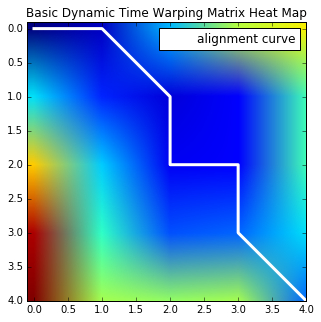

,19,10,1,0,17
13,6.0,9.0,21.0,34.0,38.0
2,23.0,14.0,10.0,12.0,27.0
2,40.0,22.0,11.0,12.0,27.0
6,53.0,26.0,16.0,17.0,23.0
17,55.0,33.0,32.0,33.0,17.0


In [7]:
# show the DTW alignment curve
b = dtw_basic(arr1, arr2)
pd.DataFrame(b, index = arr1, columns = arr2)

### Note added:

#### From the second code block, we can see the most criticized disadvantage of DTW: its space and time complexity are both $O(n^2)$. This is two for loops in the code, which gives $n\times n$ time steps and $n \times n$ cells to remember. The good new is that there exists various of ways to reduce both time and space complexity. And we will discuss in the future notebook.



### References:


[1] [動態時間歸整 | DTW | Dynamic Time Warping, McKelvin's Blog](http://blog.mckelv.in/articles/1453.html)

[2] [Dynamic time warping - Wikipedia](https://en.wikipedia.org/wiki/Dynamic_time_warping)

[3] [Similarity Measures and Dimensionality Reduction Techniques for Time Series Data Mining, Carmelo Cassisi, Placido Montalto, Marco Aliotta, Andrea Cannata and Alfredo Pulvirenti](https://www.intechopen.com/books/advances-in-data-mining-knowledge-discovery-and-applications/similarity-measures-and-dimensionality-reduction-techniques-for-time-series-data-mining)



